Data source: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza

In [35]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_palette('Set2')

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import prewitt_h,prewitt_v
from skimage.feature import local_binary_pattern

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

seed = 1

In [36]:
# The paths to the pizza and not pizza directories
pizza_dir = '/Users/jettchen/Desktop/pizza_not_pizza/pizza/'
not_pizza_dir = '/Users/jettchen/Desktop/pizza_not_pizza/not_pizza/'

In [37]:
# Create image lists
pizza_images = [imread(os.path.join(pizza_dir, file_name)) for file_name in os.listdir(pizza_dir)]
not_pizza_images = [imread(os.path.join(not_pizza_dir, file_name)) for file_name in os.listdir(not_pizza_dir)]

In [38]:
# Check the number of images in each class
len(pizza_images), len(not_pizza_images)

(983, 983)

In [39]:
# Define a function to show image
def show_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

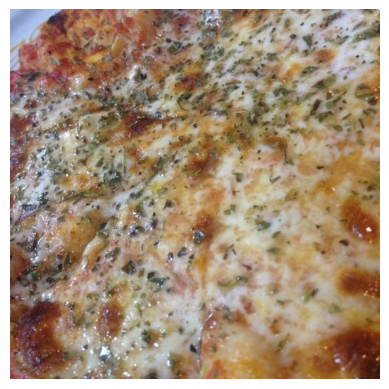

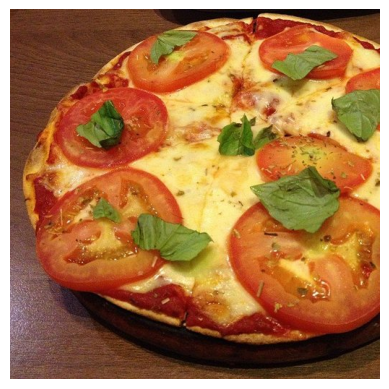

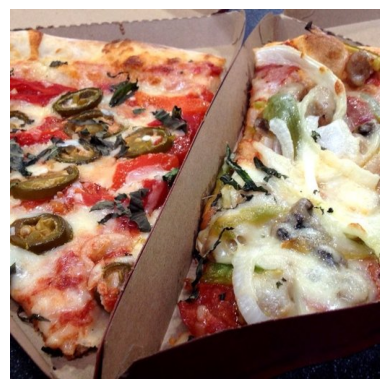

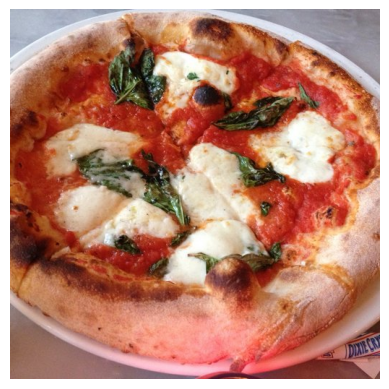

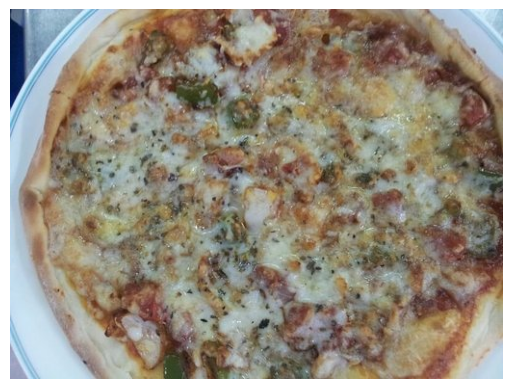

In [40]:
# Show 5 random images from the pizza folder
for i in np.random.randint(0, len(pizza_images), 5):
    show_image(pizza_images[i])

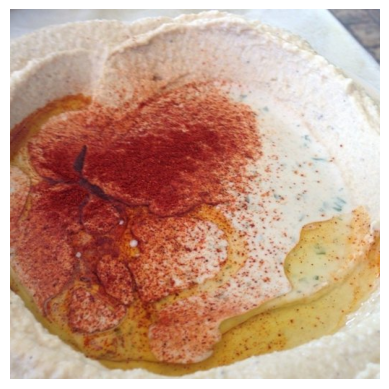

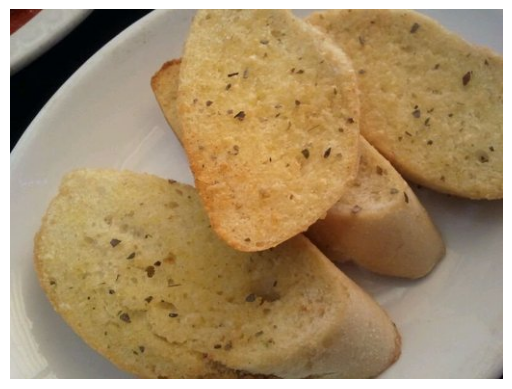

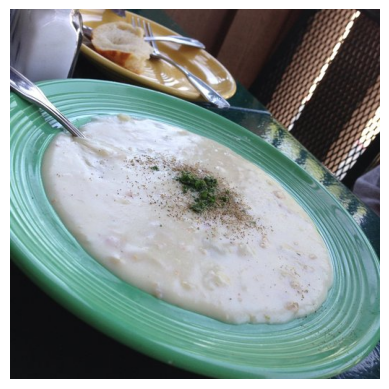

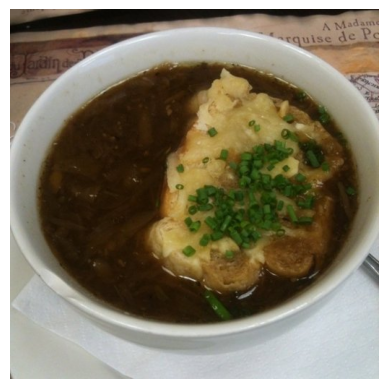

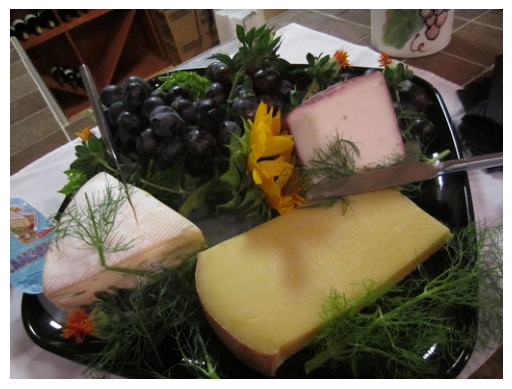

In [41]:
# Show 5 random images from the not_pizza folder
for i in np.random.randint(0, len(not_pizza_images), 5):
    show_image(not_pizza_images[i])

In [42]:
def get_rgb_features(image, size=100):
    '''
    Given an image, return a feature vector containing the average value of each channel.
    '''
    resized_img = resize(image, (size, size))
    # Sum the RGB values and divide by 3 to get the average
    rgb_matrix = resized_img[:, :, 0] + resized_img[:, :, 1] + resized_img[:, :, 2]
    rgb_avg_matrix = rgb_matrix / 3
    # Flatten the matrix into a vector
    rgb_features = np.reshape(rgb_avg_matrix, (size*size))
    
    return rgb_features

In [43]:
def get_lbp_features(image, size=100):
    '''
    Given an image, return the local binary pattern features of the image.
    '''
    resized_img = resize(image, (size, size))
    image_gray = rgb2gray(resized_img)
    # radius is the radius of the circle to consider
    # n_points is the number of points to consider on the radius
    # method is the method to determine the binary pattern and uniform is the most common one
    radius = 1
    n_points = 8 * radius
    methond = 'uniform'
    lbp_matrix = local_binary_pattern(image_gray, n_points, radius, methond)
    lbp_features = np.reshape(lbp_matrix, (size*size))
    
    return lbp_features

In [44]:
def get_edges_features(image, size=100):
    '''
    Given an image, returns the horizontal and vertical edges features of the image.
    '''
    resized_img = resize(image, (size, size))
    image_gray = rgb2gray(resized_img)
    # Using Prewitt kernel to get the edges
    horizontal_edges = prewitt_h(image_gray)
    horizontal_edges = np.reshape(horizontal_edges, (size*size)) 
    vertical_edges = prewitt_v(image_gray)
    vertical_edges = np.reshape(vertical_edges, (size*size))
    
    return horizontal_edges, vertical_edges

In [45]:
# Get features from pizza images
pizza_features = []
for image in pizza_images:
    rgb = get_rgb_features(image)
    lbp = get_lbp_features(image)
    h_edges, v_edges = get_edges_features(image)
    pizza_features.append(np.concatenate([rgb, lbp, h_edges, v_edges]))

In [46]:
# Get features from not pizza images
not_pizza_features = []
for image in not_pizza_images:
    rgb = get_rgb_features(image)
    lbp = get_lbp_features(image)
    h_edges, v_edges = get_edges_features(image)
    not_pizza_features.append(np.concatenate([rgb, lbp, h_edges, v_edges]))

In [47]:
# Create labels
pizza_labels = [1 for _ in range(len(pizza_images))]  # Represent pizza with 1
not_pizza_labels = [0 for _ in range(len(not_pizza_images))]  # Represent not pizza with 0

In [48]:
# Combine pizza and not pizza features and label
X = np.array(pizza_features + not_pizza_features)
y = np.array(pizza_labels + not_pizza_labels)

In [49]:
# Sanity check
len(X)==len(y)

True

In [50]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [51]:
# Define models and KFold
lgr = LogisticRegression(random_state=seed)
gnb = GaussianNB()
dt = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
svc = SVC(random_state=seed)
knn = KNeighborsClassifier(n_neighbors=3)
km = KMeans(n_clusters=2, random_state=seed)
models = [lgr, gnb, dt, rf, svc, knn, km]
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

In [52]:
# Cross validation using training set
cv_results = pd.DataFrame(columns=['model', 'cv_accuracy'])
for model in models:
    accuracy = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy').mean()
    cv_results = pd.concat([cv_results,
                            pd.DataFrame({
                                'model': [model.__class__.__name__],
                                'cv_accuracy': [accuracy]
                                })
                            ])
cv_results = cv_results.sort_values(by='cv_accuracy', ascending=False).reset_index(drop=True)

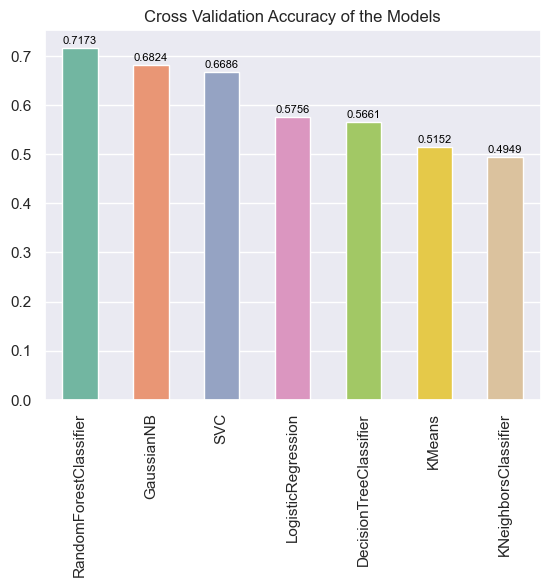

In [53]:
# plot the cross validation accuracy of the models
sns.barplot(x='model', y='cv_accuracy', data=cv_results, width=0.5)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.title('Cross Validation Accuracy of the Models')

# add annotation to the barplot
for i, acc in enumerate(cv_results['cv_accuracy']):
    plt.annotate(f'{acc:.4f}', xy=(i, acc), xytext=(0, 3),
                 textcoords='offset points', ha='center',
                 color='black', size=8)

plt.show()

In [54]:
# fit the models and predict
# print the classification report of each model
# construct a dataframe to store the classification report of the models
report_data = []
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'Classification Report of {model.__class__.__name__}:')
    print(classification_report(y_test, y_pred))
    print('------------------------------------------------------------')
    
    report = classification_report(y_test, y_pred, output_dict=True)
    model_name = model.__class__.__name__
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']

    report_data.append({'model': model_name, 'accuracy': accuracy,
                        'precision': precision, 'recall': recall, 'f1-score': f1_score})

report = pd.DataFrame(report_data)
report = report.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

Classification Report of LogisticRegression:
              precision    recall  f1-score   support

           0       0.55      0.60      0.58       303
           1       0.53      0.48      0.51       287

    accuracy                           0.54       590
   macro avg       0.54      0.54      0.54       590
weighted avg       0.54      0.54      0.54       590

------------------------------------------------------------
Classification Report of GaussianNB:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       303
           1       0.67      0.79      0.72       287

    accuracy                           0.71       590
   macro avg       0.71      0.71      0.71       590
weighted avg       0.72      0.71      0.71       590

------------------------------------------------------------
Classification Report of DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.60      0.55     

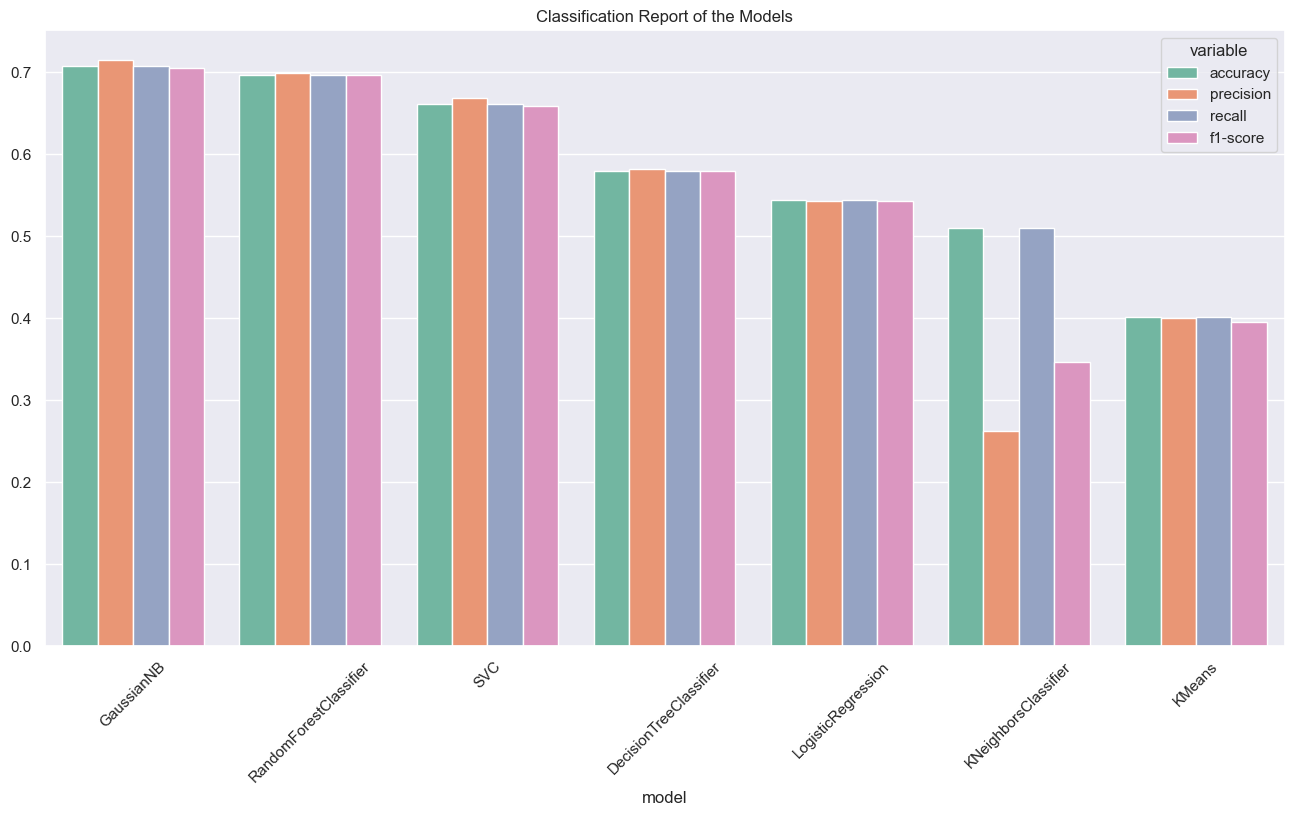

,model,accuracy,precision,recall,f1-score
0,GaussianNB,0.706780,0.715076,0.706780,0.705121
1,RandomForestClassifier,0.696610,0.699020,0.696610,0.696351
2,SVC,0.661017,0.668770,0.661017,0.658826
3,DecisionTreeClassifier,0.579661,0.581291,0.579661,0.579347
4,LogisticRegression,0.544068,0.543294,0.544068,0.542539
5,KNeighborsClassifier,0.510169,0.262893,0.510169,0.346984
6,KMeans,0.401695,0.399820,0.401695,0.394924


In [55]:
# plot the stacked barplot of the classification report
report_melt = report.melt(id_vars='model', 
                          value_vars=['accuracy' ,'precision', 'recall', 'f1-score'])

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='model', y='value', hue='variable', data=report_melt, ax=ax, width=0.8)
ax.set_ylabel('')
ax.set_title('Classification Report of the Models')

# rotate the xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

report